# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
#today = datetime.datetime.now() - datetime.timedelta(0)
#today = datetime.date.today()
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
today_str = today.isoformat()  # Convert to ISO 8601 format
tomorrow = today + datetime.timedelta(days = 1)
today_date = datetime.datetime.today().date()  # Get the current date without time
today

datetime.datetime(2024, 11, 19, 0, 0)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
os.environ["HOPSWORKS_API_KEY"] = "C4SS8dsi1TSlBcSM.FQPsjTGnxcG3aKFbWq1yzAaBw0jRlpCtRB2l7ESP9MGqHKgjMCRbpjOjbdPzJwLp"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163417
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.619907E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,-1.05,0.0,6.952754,338.749420,Majorna-Linné
1,2024-11-20 00:00:00+00:00,0.95,0.0,14.973576,9.688724,Majorna-Linné
2,2024-11-19 00:00:00+00:00,4.00,0.0,2.902413,150.255203,Majorna-Linné
3,2024-11-22 00:00:00+00:00,-4.05,0.0,5.411986,356.186005,Majorna-Linné
4,2024-11-23 00:00:00+00:00,3.75,0.0,10.163227,292.932129,Majorna-Linné
5,2024-11-24 00:00:00+00:00,2.25,0.6,28.856194,146.706421,Majorna-Linné
6,2024-11-25 00:00:00+00:00,8.55,0.6,24.627787,195.255173,Majorna-Linné
7,2024-11-26 00:00:00+00:00,8.10,0.9,31.820824,225.458298,Majorna-Linné
8,2024-11-28 00:00:00+00:00,6.50,0.0,18.532135,209.054504,Majorna-Linné
9,2024-11-27 00:00:00+00:00,4.20,0.0,7.421590,140.906158,Majorna-Linné


In [8]:
# Get weather data
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

# Read the data
air_data = air_quality_fg.read()
air_data['date'] = pd.to_datetime(air_data['date']).dt.date  # Strip the time part

# Now filter by today
air_data_today = air_data[air_data['date'] == today_date]
print(air_data_today)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 
            date  pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3 country  \
1767  2024-11-19   5.0    2.620594         2.0         9.0  Sweden   

               city      street                                 url  
1767  Majorna-Linné  Masthugget  https://api.waqi.info/feed/A60853/  


In [9]:
print(air_data)

            date   pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3 country  \
0     2021-06-21   1.40    3.520000        3.08        3.87  Sweden   
1     2019-12-27   0.98    0.770000        1.35        1.70  Sweden   
2     2020-01-11   2.04    0.850000        2.10        3.16  Sweden   
3     2023-02-01   2.06    1.120000        1.53        2.20  Sweden   
4     2022-04-03   1.40    1.100000        1.00        1.00  Sweden   
...          ...    ...         ...         ...         ...     ...   
1763  2024-11-14   6.00   18.000000       12.00        6.20  Sweden   
1764  2024-11-15  10.00    6.000000       18.00       12.00  Sweden   
1765  2024-11-16   9.00   10.000000        6.00       18.00  Sweden   
1766  2024-11-17   2.00    9.000000       10.00        6.00  Sweden   
1767  2024-11-19   5.00    2.620594        2.00        9.00  Sweden   

               city      street                                 url  
0     Majorna-Linné  Masthugget  https://api.waqi.info/feed/A60853/  
1     M

In [10]:
batch_data
batch_data['pm25_lag_1'] = air_data_today['pm25'].values[0]
batch_data['pm25_lag_2'] = air_data_today['pm25_lag_1'].values[0]
batch_data['pm25_lag_3'] = air_data_today['pm25_lag_2'].values[0]

# Ensure batch_data['date'] is a datetime object with no time (convert if needed)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.date  # Strip time from date


In [11]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-11-21,-1.05,0.0,6.952754,338.749420,Majorna-Linné,5.0,2.620594,2.0
1,2024-11-20,0.95,0.0,14.973576,9.688724,Majorna-Linné,5.0,2.620594,2.0
2,2024-11-19,4.00,0.0,2.902413,150.255203,Majorna-Linné,5.0,2.620594,2.0
3,2024-11-22,-4.05,0.0,5.411986,356.186005,Majorna-Linné,5.0,2.620594,2.0
4,2024-11-23,3.75,0.0,10.163227,292.932129,Majorna-Linné,5.0,2.620594,2.0
5,2024-11-24,2.25,0.6,28.856194,146.706421,Majorna-Linné,5.0,2.620594,2.0
6,2024-11-25,8.55,0.6,24.627787,195.255173,Majorna-Linné,5.0,2.620594,2.0
7,2024-11-26,8.10,0.9,31.820824,225.458298,Majorna-Linné,5.0,2.620594,2.0
8,2024-11-28,6.50,0.0,18.532135,209.054504,Majorna-Linné,5.0,2.620594,2.0
9,2024-11-27,4.20,0.0,7.421590,140.906158,Majorna-Linné,5.0,2.620594,2.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [12]:
# Run inference for each day sequentially, starting from the first day
for i in range(len(batch_data)-1):
    #print(f"Running inference for day {i+1}")
    current_day = today_date + datetime.timedelta(days=i+1)  # Current day (start with tomorrow)
    tomorrow = today_date + datetime.timedelta(days=i+2)  # Day after tomorrow
    
    # Filter the data for the current day
    pred_data = batch_data[batch_data['date'] == current_day]
    lag_2 = pred_data['pm25_lag_1'].values[0]
    lag_3 = pred_data['pm25_lag_2'].values[0]

    print(f"Running inference for {current_day}")
    
    # Make the prediction for the current day
    pm25_pred = retrieved_xgboost_model.predict(
        pred_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    
    # Add the prediction to the 'pm25_pred' column for the current day
    batch_data.loc[batch_data['date'] == current_day, 'predicted_pm25'] = pm25_pred

    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_1'] = pm25_pred  # Today's prediction for tomorrow's lag_1
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_2'] = lag_2  # Today's lag_1 for tomorrow's lag_2
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_3'] = lag_3  # Today's lag_2 for tomorrow's lag_3
    print(f"Predicted PM2.5 for {current_day}: {pm25_pred}")

# Show the final predictions and lag columns
print(batch_data[['date', 'predicted_pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']])


Running inference for 2024-11-20
Predicted PM2.5 for 2024-11-20: [2.3705583]
Running inference for 2024-11-21
Predicted PM2.5 for 2024-11-21: [0.89798373]
Running inference for 2024-11-22
Predicted PM2.5 for 2024-11-22: [1.245516]
Running inference for 2024-11-23
Predicted PM2.5 for 2024-11-23: [1.8596913]
Running inference for 2024-11-24
Predicted PM2.5 for 2024-11-24: [3.0918]
Running inference for 2024-11-25
Predicted PM2.5 for 2024-11-25: [4.891027]
Running inference for 2024-11-26
Predicted PM2.5 for 2024-11-26: [4.767744]
Running inference for 2024-11-27
Predicted PM2.5 for 2024-11-27: [3.281887]
Running inference for 2024-11-28
Predicted PM2.5 for 2024-11-28: [4.934805]
         date  predicted_pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3
0  2024-11-21        0.897984    2.370558    5.000000    2.620594
1  2024-11-20        2.370558    5.000000    2.620594    2.000000
2  2024-11-19             NaN    5.000000    2.620594    2.000000
3  2024-11-22        1.245516    0.897984    2.370

In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         10 non-null     object 
 1   temperature_2m_mean          10 non-null     float32
 2   precipitation_sum            10 non-null     float32
 3   wind_speed_10m_max           10 non-null     float32
 4   wind_direction_10m_dominant  10 non-null     float32
 5   city                         10 non-null     object 
 6   pm25_lag_1                   10 non-null     float32
 7   pm25_lag_2                   10 non-null     float64
 8   pm25_lag_3                   10 non-null     float64
 9   predicted_pm25               9 non-null      float32
dtypes: float32(6), float64(2), object(2)
memory usage: 688.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [14]:
# Assuming 'batch_data' and 'forecast_date' are already defined
# Ensure 'date' is in datetime format (if it's not already)
batch_data['date'] = pd.to_datetime(batch_data['date'], errors='coerce').dt.date

# Define forecast date as a pandas Timestamp
forecast_date = pd.to_datetime(datetime.date.today())  # This will convert to 'datetime64[ns]'

# Sort the DataFrame by 'date' to ensure it is in ascending order
batch_data = batch_data.sort_values(by=['date'])

# Calculate the 'days_before_forecast_day' based on the difference between each 'date' and the 'forecast_date'
batch_data['days_before_forecast_day'] = (forecast_date - pd.to_datetime(batch_data['date'])).dt.days.abs()

# Assign new columns
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country

# View the updated DataFrame
batch_data



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,days_before_forecast_day,street,country
2,2024-11-19,4.00,0.0,2.902413,150.255203,Majorna-Linné,5.000000,2.620594,2.000000,NaN,0,Masthugget,Sweden
1,2024-11-20,0.95,0.0,14.973576,9.688724,Majorna-Linné,5.000000,2.620594,2.000000,2.370558,1,Masthugget,Sweden
0,2024-11-21,-1.05,0.0,6.952754,338.749420,Majorna-Linné,2.370558,5.000000,2.620594,0.897984,2,Masthugget,Sweden
3,2024-11-22,-4.05,0.0,5.411986,356.186005,Majorna-Linné,0.897984,2.370558,5.000000,1.245516,3,Masthugget,Sweden
4,2024-11-23,3.75,0.0,10.163227,292.932129,Majorna-Linné,1.245516,0.897984,2.370558,1.859691,4,Masthugget,Sweden
5,2024-11-24,2.25,0.6,28.856194,146.706421,Majorna-Linné,1.859691,1.245516,0.897984,3.091800,5,Masthugget,Sweden
6,2024-11-25,8.55,0.6,24.627787,195.255173,Majorna-Linné,3.091800,1.859691,1.245516,4.891027,6,Masthugget,Sweden
7,2024-11-26,8.10,0.9,31.820824,225.458298,Majorna-Linné,4.891027,3.091800,1.859691,4.767744,7,Masthugget,Sweden
9,2024-11-27,4.20,0.0,7.421590,140.906158,Majorna-Linné,4.767744,4.891027,3.091800,3.281887,8,Masthugget,Sweden
8,2024-11-28,6.50,0.0,18.532135,209.054504,Majorna-Linné,3.281887,4.767744,4.891027,4.934805,9,Masthugget,Sweden


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 2 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         10 non-null     object 
 1   temperature_2m_mean          10 non-null     float32
 2   precipitation_sum            10 non-null     float32
 3   wind_speed_10m_max           10 non-null     float32
 4   wind_direction_10m_dominant  10 non-null     float32
 5   city                         10 non-null     object 
 6   pm25_lag_1                   10 non-null     float32
 7   pm25_lag_2                   10 non-null     float64
 8   pm25_lag_3                   10 non-null     float64
 9   predicted_pm25               9 non-null      float32
 10  days_before_forecast_day     10 non-null     int64  
 11  street                       10 non-null     object 
 12  country                      10 non-null     object 
dtypes: float32(6), float64(2), i

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-19 11:31:31,914 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



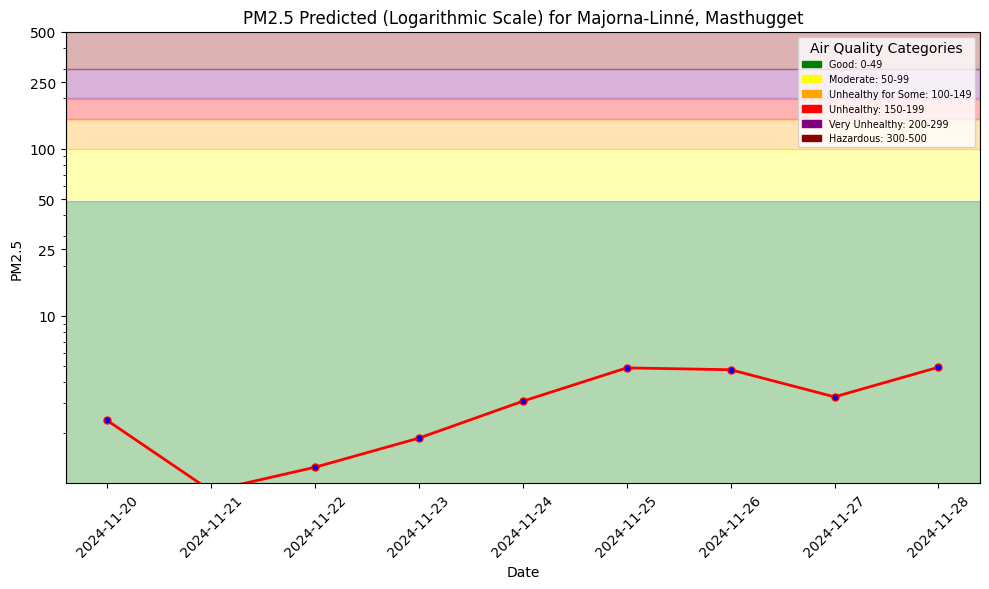

In [16]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [18]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163417/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2965c30d0>, None)

In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18,7.80,1.1,42.357792,238.201126,Majorna-Linné,3.52499,3.733772,4.236832,4.053681,Masthugget,Sweden,1
1,2024-11-13,8.45,0.0,16.394829,199.230759,Majorna-Linné,12.00000,6.200000,6.070000,9.332541,Masthugget,Sweden,1
2,2024-11-14,6.85,0.0,3.096837,324.462250,Majorna-Linné,20.00000,12.000000,6.200000,7.215687,Masthugget,Sweden,1
3,2024-11-16,7.85,0.7,29.834423,261.674438,Majorna-Linné,9.00000,6.000000,18.000000,3.272138,Masthugget,Sweden,1
4,2024-11-17,8.30,0.0,29.627363,274.879181,Majorna-Linné,10.00000,10.000000,6.000000,3.556387,Masthugget,Sweden,1
5,2024-11-20,0.95,0.0,14.973576,9.688724,Majorna-Linné,5.00000,2.620594,2.000000,2.370558,Masthugget,Sweden,1


In [20]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2021-06-21 00:00:00+00:00,1.40,3.520000,3.08,3.87,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1,2019-12-27 00:00:00+00:00,0.98,0.770000,1.35,1.70,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
2,2020-01-11 00:00:00+00:00,2.04,0.850000,2.10,3.16,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
3,2023-02-01 00:00:00+00:00,2.06,1.120000,1.53,2.20,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
4,2022-04-03 00:00:00+00:00,1.40,1.100000,1.00,1.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
...,...,...,...,...,...,...,...,...,...
1763,2024-11-14 00:00:00+00:00,6.00,18.000000,12.00,6.20,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1764,2024-11-15 00:00:00+00:00,10.00,6.000000,18.00,12.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1765,2024-11-16 00:00:00+00:00,9.00,10.000000,6.00,18.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1766,2024-11-17 00:00:00+00:00,2.00,9.000000,10.00,6.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/


In [21]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

print(outcome_df, 'outcome_df')
print(preds_df, 'preds_df')

# Convert 'date' columns to datetime, removing any time zone info if necessary
outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)  # Remove timezone if present
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)  # Remove timezone if present

# Now merge the DataFrames
hindcast_df = pd.merge(preds_df, outcome_df, on="date")

# View the resulting DataFrame
print(hindcast_df)

hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

                          date   pm25
0    2021-06-21 00:00:00+00:00   1.40
1    2019-12-27 00:00:00+00:00   0.98
2    2020-01-11 00:00:00+00:00   2.04
3    2023-02-01 00:00:00+00:00   2.06
4    2022-04-03 00:00:00+00:00   1.40
...                        ...    ...
1763 2024-11-14 00:00:00+00:00   6.00
1764 2024-11-15 00:00:00+00:00  10.00
1765 2024-11-16 00:00:00+00:00   9.00
1766 2024-11-17 00:00:00+00:00   2.00
1767 2024-11-19 00:00:00+00:00   3.00

[1768 rows x 2 columns] outcome_df
         date  predicted_pm25
0  2024-11-18        4.053681
1  2024-11-13        9.332541
2  2024-11-14        7.215687
3  2024-11-16        3.272138
4  2024-11-17        3.556387
5  2024-11-20        2.370558 preds_df
2024-11-19 11:34:41,723 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,date,predicted_pm25,pm25
0,2024-11-13,9.332541,18.0
1,2024-11-14,7.215687,6.0
2,2024-11-16,3.272138,9.0
3,2024-11-17,3.556387,2.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

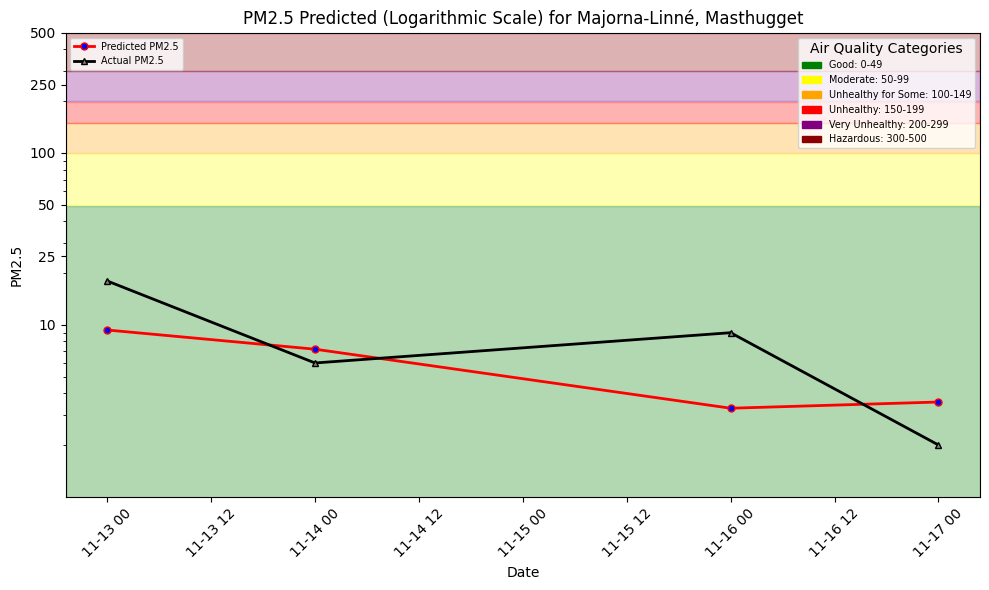

In [22]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---